## To do:

-- pruning (done)

-- remove for loops from split function (forget numpy.vectorize \- works slower)

-- add weights (later) $$p = \frac{ \sum_{x_i \in R} W*I_{\{y_i = 1\}}}{\sum_{x_i \in R}W \cdot I_{\{y_i = 1\}}+\sum_{x_i \in R}I_{\{y_i = 0\}}}$$

-- add entropy and misclasification improvement to classification tree (later)

-- cython functions to speed up 

-- visualize a tree

-- add regression tree

-- save and read model


In [7]:
import operator
import pandas
import numpy
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings("ignore")

In [8]:
def gini_improvement(x,y):
    # x - one column of the original X array
    # y - Y array
    x_uvals, inv, q_l = numpy.unique(x, return_inverse = True, return_counts=True)
    m = x_uvals.shape[0]
    n = inv.shape[0]
    p_l = csr_matrix((numpy.ones(n),(inv, numpy.arange(n)))).dot(y)
    p_l = numpy.cumsum(p_l,dtype = float)
    q_l = numpy.cumsum(q_l,dtype = float)
    val_l = p_l/q_l
    
    p_r = p_l[-1] - p_l
    q_r = n - q_l
    val_r = p_r/q_r
    
    p = p_l[-1]/n
    g = 1 - numpy.square(p) - numpy.square(1 - p)
    
    p_l = p_l/q_l
    p_r = p_r/q_r
    g_l = 1 - numpy.square(p_l) - numpy.square(1 - p_l)
    g_r = 1 - numpy.square(p_r) - numpy.square(1 - p_r)
    q_l = 1.0*q_l/n
    q_r = 1.0*q_r/n
    gini_improvements  = g - q_l*g_l-q_r*g_r 
    idx = gini_improvements[:-1].argmax()
    return (gini_improvements[idx],0.5*(x_uvals[idx]+x_uvals[idx+1]),val_l[idx],val_r[idx])
    
    

def split(x,y,parent,threshold):
        # go over all columns compute information gain from a split
        # all columns are assumed to be numeric
        
        # add subindexing of x and y according to parent rule
        time_in_split = 0
        time_in_gini_improvement = 0
        idx = numpy.ones(x.shape[0],dtype = bool)
        for r in parent.rule:
            idx = idx*r[2](x[:,r[0]],r[1]) 
        if idx.sum() <2:
            parent.info_improvement = 0
            return False
                
        n,m = x[idx,:].shape
        max_imp = 0 
        max_imp_col = None
        max_imp_cut = None
        for j in range(0,m):
            improvement, cut, val_l,val_r = gini_improvement(x[idx,j],y[idx])
            if max_imp < improvement:
                max_imp = improvement
                max_imp_col = j
                max_imp_cut = cut
                max_val_l = val_l
                max_val_r = val_r
     
        if max_imp > threshold:
            # create left and right node with cut value = min_imp_cut of column max_imp_col
            parent.info_improvement = max_imp
            parent.left = Node(max_imp_col,max_imp_cut,operator.le,max_val_l,parent)
            parent.right = Node(max_imp_col,max_imp_cut,operator.gt,max_val_r,parent)
            return True
        else:
            parent.info_improvement = 0
            return False
        

    
def entropy():
    return 0    
        
def newf():
    return 0


In [9]:
class Node:
            
    def __init__(self,col,split_value,oper,value = None,parent = None):
        self.parent = parent
        if parent is None:
            self.rule = [(col,split_value,operator.ne)]
        else:
            self.rule = parent.rule + [(col,split_value,oper)]
        self.value = value
        self.left = None
        self.right = None
        self.info_improvement = None
        
    
    def __lt__(self,other):
        return self.info_improvement < other.info_improvement
        
    def __repr__(self,indent=0):
        side_dict = {-1:'left',0:'root',1:'right'}
        return str({'col': self.rule[-1][0], 'split value':self.rule[-1][1],#'side':side_dict[self.side],
                    'info improvement':self.info_improvement, 'value':self.value})
    
    def __str__(self):
        return ('Node{ rule: ' + str(self.rule[1:]) +
                '\n'+'value: ' + str(self.value) +
                '\n'+'info_inprovement: ' + str(self.info_improvement) +'}')
                
    def prt(self):
        side_dict = {-1:'left',0:'root',1:'right'}
        indent = len(self.rule)-1
        return (indent*'\t' + '{column: ' + str(self.rule[-1][0]) + '\n'+    
                indent*'\t' + ' split: '+str(self.rule[-1][1]) + '\n'+
                indent*'\t' + ' info_inprovement: ' + str(self.info_improvement) + '\n'+
                indent*'\t' + ' value: ' + str(self.value) + '}\n')
    
    def compute_value(self,x,y):
        idx = numpy.array(range(x.shape[0]))
        idx = idx > -1
        for r in self.rule:
            idx == idx*r[2](x[:,r[0]],r[1])
            
        self.value = y[idx].mean()
        
    def colapse_cost(self, x,y,alpha):
        return (self.info_improvement - alpha)
    
    def colapse(self):
        self.left = None
        self.right = None

In [19]:
class ClassificationTree:
    def __init__(self, n=None, impurity = 'gini', max_leaves = None, min_improvment = 0):
        
        # impurity - choise of impurity function
        # leaf_count -  number of leaves
        # threshgold - minimum information improvement for a split
                
        self.max_leaves = max_leaves
        
        self.impurity = impurity
        self.root = Node(None,None,operator.ne)
        
        self.leaf_count = 0
        
        self.threshold = min_improvment
        self.leaves = []
    
    
    
    def __str__(self):
        value = ''
        nodes = [self.root]
        while len(nodes)>0:
            current_node = nodes.pop()
            value = value + current_node.prt()
            if not(current_node.right is None):
                nodes.append(current_node.right)
            if not(current_node.left is None):    
                nodes.append(current_node.left)
        return value
            
    def fit(self,x,y):
        # fit breadth first until max_leaves limit is reached
        print ('fitting ...') 
        x = numpy.array(x)
        y = numpy.array(y)
        leaves = []
        if split(x,y,self.root,self.threshold):
            if split(x,y,self.root.left,self.threshold):
                leaves.append(self.root.left)
                self.leaf_count += 1
            if split(x,y,self.root.right,self.threshold):
                leaves.append(self.root.right)
                self.leaf_count += 1
            leaves.sort()
                
        while (len(leaves)>0) and ((self.max_leaves is None) or (self.leaf_count < self.max_leaves)):
            next_node = leaves.pop()
            if split(x,y,next_node.left,self.threshold):
                leaves.append(next_node.left)
                self.leaf_count += 1
            if split(x,y,next_node.right,self.threshold):
                leaves.append(next_node.right)
                self.leaf_count += 1
            leaves.sort()
            
        for leaf in leaves:
            leaf.left = None
            leaf.right = None  
        
        print ('done')
        return 
    
    
   
    
    def fit_recursively(self,x,y,node = None,initial = True):
        # fit depth first complete tree
        if initial:
            x = numpy.array(x)
            y = numpy.array(y)
            node = self.root
            self.leaf_count = 1
        if split(x,y,node,self.threshold):
            self.leaf_count += 1
            self.fit_recursively(x,y,node.left, initial = False)
            self.fit_recursively(x,y,node.right,initial = False)
        return 
            
    def fitCART_old(self,x,y,alpha = 0):
        # fit complete tree 
        self.fit_recursively(x,y,alpha)
        # prune
        num_nodes = self.leaf_count*2 - 1
        
        # get all leaves
        leaves = []
        current_node = self.root
        continue_cond = True
        while continue_cond:
            if current_node.left is None:
                leaves.append(current_node)
                if current_node.parent.left is current_node:
                    current_node = current_node.parent.right
                else:
                    while (not current_node is self.root) and \
                          (current_node.parent.right is current_node):
                        current_node = current_node.parent
                    if current_node is self.root:
                        continue_cond = False
                    else:
                        current_node = current_node.parent.right
            else:
                current_node = current_node.left
        
        return
    
    def fitCART(self,x,y,alpha = 0):
        # fit complete tree 
        self.root.value = y.mean()
        #self.fit_recursively(x,y,alpha)
        self.fit_recursively(x,y)
        # prune
        num_nodes = self.leaf_count*2 - 1
        
        # get all leaves
        leaves = []
        current_node = self.root
        continue_cond = True
        while continue_cond: 
            if current_node.left is None:
                if current_node.parent.left is current_node:
                    current_node = current_node.parent.right
                #---------------------------------
                # if right colapse here right with left if improves
                else:
                    while (not current_node is self.root) and \
                          (current_node.parent.right is current_node):
                        if current_node.parent.colapse_cost(x,y,alpha) < 0:
                            current_node = current_node.parent
                            current_node.colapse()
                        else:
                            current_node = current_node.parent
                    if current_node is self.root:
                        continue_cond = False
                    else:
                        current_node = current_node.parent.right
            else:
                current_node = current_node.left
        
        #recompute number of leaves
        self.leaf_count = len(self.get_leaves())  
        return
    
    
    def get_leaves(self):
        leaves = []
        current_node = self.root
        continue_cond = True
        while continue_cond: 
            if current_node.left is None:
                leaves.append(current_node)
                if current_node is self.root:
                        continue_cond = False
                elif current_node.parent.left is current_node:
                    current_node = current_node.parent.right
                else:
                    while (not current_node is self.root) and \
                          (current_node.parent.right is current_node):
                        current_node = current_node.parent
                    if current_node is self.root:
                        continue_cond = False
                    else:
                        current_node = current_node.parent.right
            else:
                current_node = current_node.left
        
        return leaves
        
    def predict_one(self,x):
            current_node = self.root
            while current_node.left != None:
                j = current_node.left.rule[-1][0]
                cut_value = current_node.left.rule[-1][1]
                if x[j] <= cut_value:
                    current_node = current_node.left
                else:
                    current_node = current_node.right
            return current_node.value
    
    
    
    def predict(self, x):
        # predict y for given x
        return numpy.apply_along_axis(self.predict_one,1,x)
    
    

Create random 2d array of data of mixture of two gaussinas

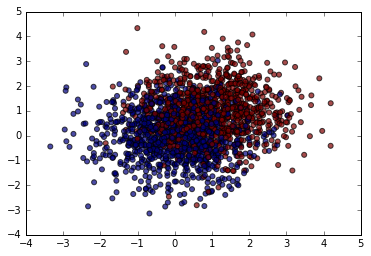

In [20]:
import pandas
import random

# generate random 2 column set with target 0 
x1_1 = numpy.random.normal(0,1,1000)
x1_2 = numpy.random.normal(0,1,1000)
y1 = numpy.zeros(1000)
df = pandas.DataFrame({'x1':x1_1, 'x2':x1_2,'y':y1})
# generate random 2 column set with target 1
x2_1 = numpy.random.normal(1,1,1000)
x2_2 = numpy.random.normal(1,1,1000)
y2 = numpy.ones(1000)
df = pandas.concat([df,pandas.DataFrame({'x1':x2_1, 'x2':x2_2,'y':y2})], ignore_index = True)
# reshuffle
idx = random.sample(list(df.index),len(df.index))
df = df.ix[idx]
df.reset_index(inplace = True)
df.drop('index',axis = 1,inplace = True)
# plot
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(df['x1'],df['x2'],s=25,c = df['y'],alpha=0.7)
plt.show()

In [21]:
# my tree fit time
import time
model = ClassificationTree(max_leaves = None)
begin = time.time()
model.fit(df[['x1','x2']],df['y'])
print 'Fitting time: ', time.time() - begin

fitting ...
done
Fitting time:  0.785758972168


In [22]:
# my tree fit recursively time
model = ClassificationTree(max_leaves = None)
begin = time.time()
model.fit_recursively(df[['x1','x2']],df['y'])
print 'Fitting time: ', time.time() - begin

Fitting time:  0.735265016556


In [23]:
# my tree fitCART time
model = ClassificationTree(max_leaves = None)
begin = time.time()
model.fitCART(df[['x1','x2']],df['y'],alpha = 0.03)
print 'Fitting time: ', time.time() - begin

Fitting time:  0.735790014267


In [24]:
print len(model.get_leaves())

10


In [25]:
print (model.root)

Node{ rule: []
value: 0.5
info_inprovement: 0.0792653338509}


Predicting time:  0.0502882003784
leaf count:  10
misclassification:  489.0


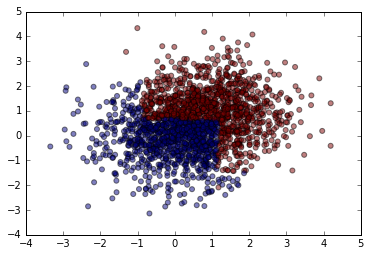

In [26]:
# my tree predict
begin = time.time()
y_predict = model.predict(df[['x1','x2']])
print 'Predicting time: ', time.time() - begin

print "leaf count: ", model.leaf_count
print 'misclassification: ',numpy.absolute((y_predict>0.5) - numpy.array(df['y'])).sum()

plt.scatter(df['x1'],df['x2'],s=25,c = y_predict>0.5,alpha=0.5)
plt.show()



Fitting time:  0.0108840465546
Predicting time:  0.00265693664551
Misclassification:  502
Number of leaves:  10


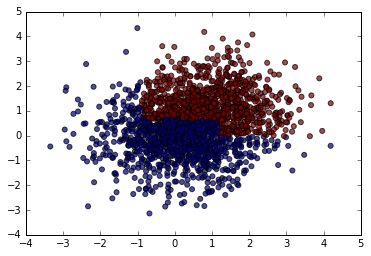

In [27]:
# sklearn tree
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_leaf_nodes=10)
begin = time.time()
clf = clf.fit(df[['x1','x2']],df['y'])
print 'Fitting time: ', time.time() - begin
begin = time.time()
y_pred = clf.predict(df[['x1','x2']])
print 'Predicting time: ', time.time() - begin

print 'Misclassification: ',sum(numpy.absolute(y_pred - numpy.array(df['y']))> 0.5)
leaves = clf.apply(df[['x1','x2']])
print 'Number of leaves: ',len(numpy.unique(leaves))

plt.scatter(df['x1'],df['x2'],s=25,c = y_pred,alpha=0.7)
plt.show()